In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import json

%pylab inline

In [2]:
import itertools
from math import radians, cos, sin, asin, sqrt

In [5]:
# This is a mockup of what would be **Jiheng's list**.
     
import itertools
import random

zipcodedistance = pd.read_csv("ZipcodeDistance.csv")

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    meters = 6373 * 1000 * c
    return meters

In [49]:
g=open('input_files/uniqueCitiBikeZips.txt')
cbikelist = map(int, g.read().split("\n")[0].split("\t")[:-1])

In [50]:
dist_dict = {}
for subset in itertools.product(cbikelist,cbikelist):
    lon1 = zipcodedistance['Longitude'][zipcodedistance['Zip'] == subset[0]]
    lat1 = zipcodedistance['Latitude'][zipcodedistance['Zip'] == subset[0]]
    lon2 = zipcodedistance['Longitude'][zipcodedistance['Zip'] == subset[1]]
    lat2 = zipcodedistance['Latitude'][zipcodedistance['Zip'] == subset[1]]
    dist_dict[str(subset[0])+str(subset[1])] = haversine(lon1, lat1, lon2, lat2)

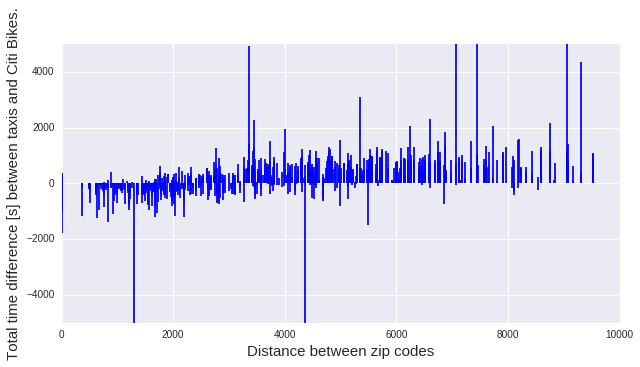

In [70]:
"""
Create pairs for total trips
"""

f = open('./results/results_TotalJanMaySept', 'r')
pairs = f.read().split("\n")

dict_total = {}
zip_pair_pre = None
cnt = 0
tm_list = []
mode_list = []
for item in pairs[:-1]:
    #print(item)
    trip, av_time, count = item.split("\t") #  
    zip_pair, mode = trip.split("|")
    zip_origin, zip_destin = zip_pair[:5], zip_pair[5:]
    if zip_pair == zip_pair_pre:
        cnt += 1
    else:
        if cnt == 2 and len(set(mode_list))==2:
            # Taxis - Citi bike
            #dict_total[zip_pair_pre] = [100*((float(tm_list[-2:][1]) - float(tm_list[-2:][0]) )/ float(tm_list[-2:][1])), dist_dict[zip_pair_pre] ]
            # Structure of the dictionay values: difference (taxis - bikes), distance, Citi Bike time, Taxi time.            
            dict_total[zip_pair_pre] = [float(tm_list[-2:][1]) - float(tm_list[-2:][0]) , dist_dict[zip_pair_pre] ,float(tm_list[-2:][0]) ,float(tm_list[-2:][1]), 100*(float(tm_list[-2:][1]) - float(tm_list[-2:][0]))/float(tm_list[-2:][1])  ]
            #print("yup!")
            tm_list = []
            mode_list = []
        cnt=1
    zip_pair_pre = zip_pair
    tm_list.append(av_time)
    mode_list.append(mode)

plt.figure(figsize=(10,5))
plt.vlines([val[1] for val in dict_total.values()], [0],[val[0] for val in dict_total.values()],color='blue')
plt.ylim(-5000, 5000)
plt.xlabel("Distance between zip codes",fontsize=15)
plt.ylabel("Total time difference [s] between taxis and Citi Bikes.",fontsize=15)

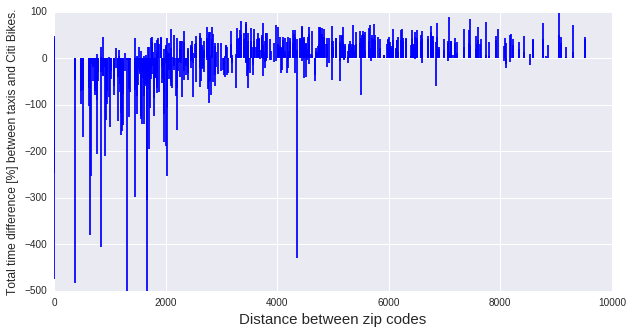

In [75]:
plt.figure(figsize=(10,5))
plt.vlines([val[1] for val in dict_total.values()], [0],[val[4] for val in dict_total.values()],color='blue')
plt.ylim(-500, 100)
plt.xlabel("Distance between zip codes",fontsize=15)
plt.ylabel("Total time difference [%] between taxis and Citi Bikes.",fontsize=12)

Mean for Citi bike: 1095.32880099
Mean for Taxis: 1386.84177998


/home/saf537/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


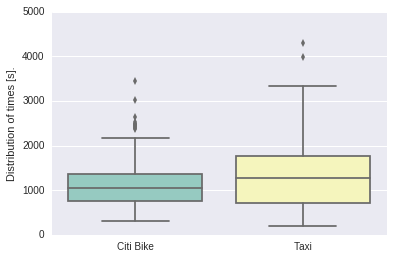

In [9]:
Total_trips = pd.DataFrame({"Citi Bike": [val[2] for val in dict_total.values()], "Taxi":[val[3] for val in dict_total.values()]},columns=["Citi Bike","Taxi"])
    
print "Mean for Citi bike: "+str(np.mean([val[2] for val in dict_total.values()]))
print "Mean for Taxis: " +str(np.mean([val[3] for val in dict_total.values()]))

ax = sns.boxplot(Total_trips,palette="Set3")
ax.set_ylim(0,5000)
ax.set( ylabel= "Distribution of times [s].")


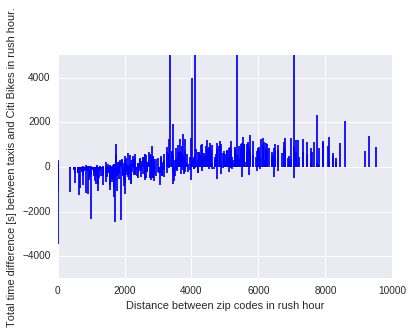

In [22]:

"""

Crete pairs for weekday rush vs. non-rush scenarios.

"""

f = open('./results/results_RushJanMaySept', 'r')
pairs = f.read().split("\n")

dict_rush = {}
zip_pair_pre = None
cnt = 0
tm_list = []
mode_list = []
for item in pairs[:-1]:
    #print(item)
    trip, av_time, count = item.split("\t") #  
    zip_pair, form = trip.split("|")
    mode, rush = form.split("&")
    zip_origin, zip_destin = zip_pair[:5], zip_pair[5:]
    if zip_pair == zip_pair_pre:
        cnt += 1
    else:
        if cnt == 4 and len(set(mode_list))==2:
            # citibike&rush, citibike&valley, taxis&rush, taxis&valley 
            # Taxi - Citi bike rush, Taxi - Citi Bike non rush
            dict_rush[zip_pair_pre] = [['rush','valley'],  float(tm_list[-4:][2]) - float(tm_list[-4:][0]),float(tm_list[-4:][3]) - float(tm_list[-4:][1])  , dist_dict[zip_pair_pre]] #100*((float(tm_list[-2:][1]) - float(tm_list[-2:][0]) )/ float(tm_list[-2:][1])) 
            #print("Si")
            tm_list = []
            mode_list = []
        cnt=1
    zip_pair_pre = zip_pair
    tm_list.append(av_time)
    mode_list.append(mode)


plt.vlines([val[3] for val in dict_rush.values()], [0],[val[1] for val in dict_rush.values()],color='blue')
plt.ylim(-5000, 5000)
plt.xlabel("Distance between zip codes in rush hour")
plt.ylabel("Total time difference [s] between taxis and Citi Bikes in rush hour.")

Mean difference in rush hour: 253.708933718
Mean difference in non rush hour: -154.808357349


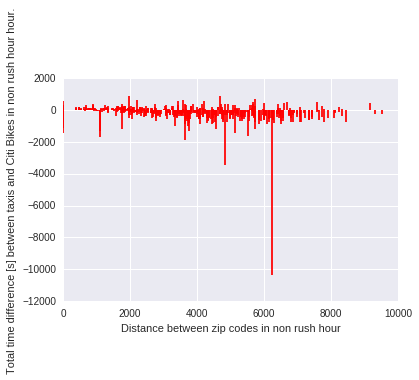

In [11]:

plt.vlines([val[3] for val in dict_rush.values()], [0],[val[2] for val in dict_rush.values()],color='red')
plt.xlabel("Distance between zip codes in non rush hour")
plt.ylabel("Total time difference [s] between taxis and Citi Bikes in non rush hour hour.")

print "Mean difference in rush hour: "+str(np.mean([val[1] for val in dict_rush.values()]))
print "Mean difference in non rush hour: " +str(np.mean([val[2] for val in dict_rush.values()]))



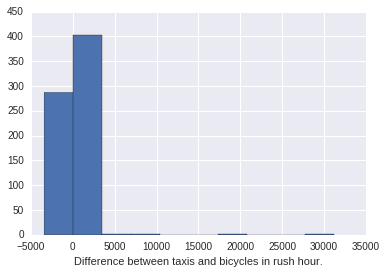

In [12]:

plt.hist([val[1] for val in dict_rush.values()])
plt.xlabel("Difference between taxis and bicycles in rush hour.")


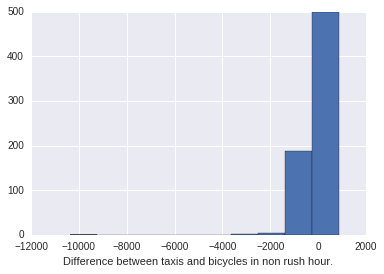

In [13]:

plt.hist([val[2] for val in dict_rush.values()])
plt.xlabel("Difference between taxis and bicycles in non rush hour.")


In [14]:
"""

Create pairs for weekend day vs-night scenarios.

"""
    
f = open('./results/results_SaturdayJanMaySept', 'r')
pairs = f.read().split("\n")

dict_weekend = {}
zip_pair_pre = None
cnt = 0
tm_list = []
mode_list = []
for item in pairs[:-1]:
    #print(item)
    trip, av_time, count = item.split("\t") #  
    zip_pair, form = trip.split("|")
    mode, rush = form.split("&")
    zip_origin, zip_destin = zip_pair[:5], zip_pair[5:]
    if zip_pair == zip_pair_pre:
        cnt += 1
    else:
        if cnt == 4 and len(set(mode_list))==2:
            # citibike&day, citibike&night, taxis&day, taxis&night  
            dict_weekend[zip_pair_pre] = [['day','night'],  float(tm_list[-4:][2]) - float(tm_list[-4:][0]) ,float(tm_list[-4:][3]) - float(tm_list[-4:][1]), dist_dict[zip_pair_pre] ] #100*((float(tm_list[-2:][1]) - float(tm_list[-2:][0]) )/ float(tm_list[-2:][1])) 
            #print("Si")
            tm_list = []
            mode_list = []
        cnt=1
    zip_pair_pre = zip_pair
    tm_list.append(av_time)
    mode_list.append(mode)

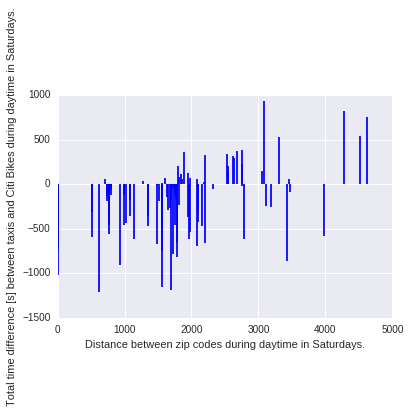

In [15]:
plt.vlines([val[3] for val in dict_weekend.values()], [0],[val[1] for val in dict_weekend.values()],color='blue')
plt.xlabel("Distance between zip codes during daytime in Saturdays.")
plt.ylabel("Total time difference [s] between taxis and Citi Bikes during daytime in Saturdays.")

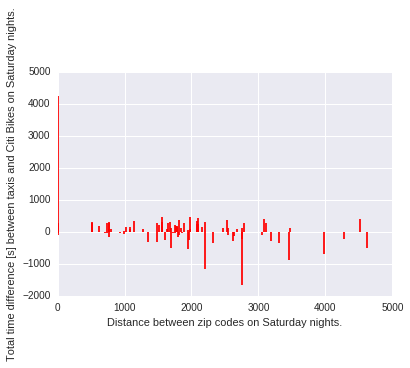

In [16]:
plt.vlines([val[3] for val in dict_weekend.values()], [0],[val[2] for val in dict_weekend.values()],color='red')
plt.xlabel("Distance between zip codes on Saturday nights.")
plt.ylabel("Total time difference [s] between taxis and Citi Bikes on Saturday nights.")

In [17]:
print "Mean difference on Saturday daytime: "+str(np.mean([val[1] for val in dict_weekend.values()]))
print "Mean difference on Saturday night: " +str(np.mean([val[2] for val in dict_weekend.values()]))

Mean difference on Saturday daytime: -215.936842105
Mean difference on Saturday night: 65.8421052632


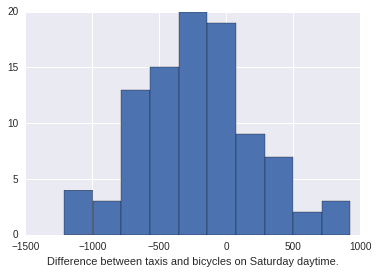

In [18]:
plt.hist([val[1] for val in dict_weekend.values()])
plt.xlabel("Difference between taxis and bicycles on Saturday daytime.")

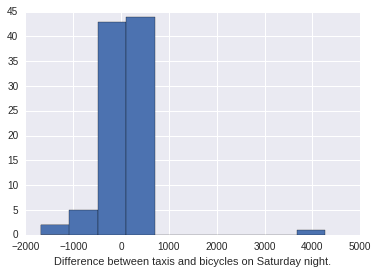

In [19]:
plt.hist([val[2] for val in dict_weekend.values()])
plt.xlabel("Difference between taxis and bicycles on Saturday night.")

In [20]:
# -- Save dictionaries in json files  
  
import json
with open('./results/total_trips.json', 'w') as fp:
    json.dump(dict_total, fp)
    
with open('./results/rush_nonrush.json', 'w') as fp:
    json.dump(dict_rush, fp)

with open('./results/total_weekends.json', 'w') as fp:
    json.dump(dict_weekend, fp)  
     